In [139]:
%matplotlib inline
import sys
import queue
import copy
import math
import pandas as pd
import networkx as nx
from itertools import combinations

In [140]:
# 기존 형식과 유사하게 Node class 정의
class Node:
    def __init__(self, linkedNode, latitude, longitude):
        self.linkedNode = linkedNode
        self.latitude = latitude
        self.longitude = longitude

In [141]:
# node_list 정의(바둑판식 6x6)
node_list = []
for i in range(0, 36):
    linkedNode = []
    if i+1 < 36 and (i+1)%6 != 0:
        linkedNode.append(i+1)
    if i-1 > -1 and (i-1)%6 != 5:
        linkedNode.append(i-1)
    if i+6 < 36:
        linkedNode.append(i+6)
    if i-6 > -1:
        linkedNode.append(i-6)
    node_list.append(Node(linkedNode, i%6, i//6))

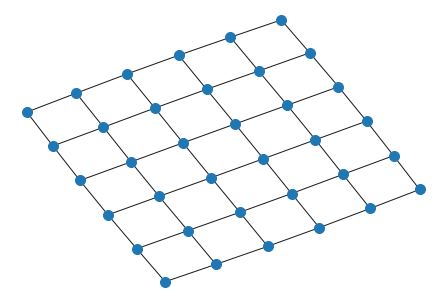

In [142]:
# 전체 그래프
G = nx.Graph()

# 0~35까지 노드 추가
for i in range(0, len(node_list)):
    G.add_node(i)

# 바둑판 식으로 edge 추가
for i in range(0, len(node_list)):
    for j in node_list[i].linkedNode:
        G.add_edge(i, j)

nx.draw(G, nx.kamada_kawai_layout(G), with_labels=False, node_size=100)

In [143]:
class CopNextNodes:
    def __init__(self, _distance=0, _nextNode=[]):
        self.distance = _distance
        self.nextNode = copy.deepcopy(_nextNode)

In [144]:
def BFS_next_nodes(startID, endID):
    costs = {}
    parents = {}

    currentID = startID
    q = queue.Queue()
    q.put(currentID)
    costs[currentID] = 0

    while not q.empty():
        currentID = q.get()

        for nextID in node_list[currentID].linkedNode:
            if (nextID in costs and costs[nextID] >= costs[currentID] + 1) or nextID not in costs:
                costs[nextID] = costs[currentID] + 1
                if nextID not in parents:
                    parents[nextID] = []
                if currentID not in parents[nextID]:
                    parents[nextID].append(currentID)
                q.put(nextID)

    next_nodes = [endID]
    distance = 0

    if endID != startID:
        distance += 1

        while parents[next_nodes[0]][0] != startID:
            new_next_nodes = []
            for next_node in next_nodes:
                for parent_node in parents[next_node]:
                    if parent_node not in new_next_nodes:
                        new_next_nodes.append(parent_node)
            next_nodes = copy.deepcopy(new_next_nodes)
            distance += 1

    return CopNextNodes(distance, next_nodes)

In [145]:
# 순열 도출
def permutations(array, c):
    if len(array) >= c:
        return permutations_2(array, c)
    else:
        return permutations_3(array, c)

In [146]:
# 중복x  길이 c 수보다 많거나 같을 때
def permutations_2(array, c):
    for i in range(len(array)):
        if c == 1:
            yield [array[i]]
        else:
            for next in permutations_2(array[:i]+array[i+1:], c-1):
                yield [array[i]] + next

In [147]:
# 중복o 길이 c 수보다 작을 때
def permutations_3(array, c, turn = 0, number_of_dest=[], cop_goal_array=[]):
    if turn > c - 1:
        yield cop_goal_array
        return
        
    if turn == 0:
        number_of_dest = [0 for i in range(len(array))]
        cop_goal_array = [0 for i in range(c)]

    for dest in range(0, len(array)):

        copy_number_of_dest = number_of_dest.copy()
        copy_cop_goal_array = cop_goal_array.copy()

        if copy_number_of_dest[dest] < c // len(array) + 1:
            copy_cop_goal_array[turn] = dest
            copy_number_of_dest[dest] += 1
            for next in permutations_3(array, c, turn+1, copy_number_of_dest, copy_cop_goal_array):
                yield next

In [148]:
# new cur cop node에서 rob node까지의 벡터 합이 0에 가까우면 True 반환
def sum_vector_power(new_cop_nodes, old_cop_nodes, rob_node):
    new_cop_vector_sum = 0
    old_cop_vector_sum = 0
    for cop in new_cop_nodes:
        new_cop_vector_sum += math.cos(math.atan2(node_list[rob_node].longitude - node_list[cop].longitude, node_list[rob_node].latitude - node_list[cop].latitude))
    for cop in old_cop_nodes:
        old_cop_vector_sum += math.cos(math.atan2(node_list[rob_node].longitude - node_list[cop].longitude, node_list[rob_node].latitude - node_list[cop].latitude))

    if abs(new_cop_vector_sum) < abs(old_cop_vector_sum):
        return True
    else:
        return False

In [149]:
# 다음 node가 rob 위치인지 판별
def cal_next_cop_node(next_node=None, next_cop_node=None, cur_rob_node=None, distance = 0):
    if next_node == cur_rob_node or next_cop_node == cur_rob_node or distance == 0:
        return cur_rob_node
    else:
        return next_node

In [150]:
def MoveNode(cur_cop_nodes, cur_rob_node):
    cops_next = []

    for i, cop_node in enumerate(cur_cop_nodes):
        cops_next.append([])
        for linkedNode in node_list[cur_rob_node].linkedNode:
            cops_next[i].append(BFS_next_nodes(cop_node, linkedNode))

    next_cop_nodes = copy.deepcopy(cur_cop_nodes)
    min_weight = 10000000

    for index in permutations(list(range(0, len(node_list[cur_rob_node].linkedNode))), len(cur_cop_nodes)):
        weight = 0
        for i in range(0, len(cur_cop_nodes)):
            weight += cops_next[i][index[i]].distance
        
        temp_next_cop_nodes = []
        for i in range(0, len(cur_cop_nodes)):
            temp_next_cop_nodes.append(cal_next_cop_node(cops_next[i][index[i]].nextNode[0], next_cop_nodes[i], cur_rob_node, cops_next[i][index[i]].distance))
        
        if weight < min_weight:
            min_weight = weight
            next_cop_nodes = copy.deepcopy(temp_next_cop_nodes)

        elif weight == min_weight and sum_vector_power(temp_next_cop_nodes, next_cop_nodes, cur_rob_node):
            next_cop_nodes = copy.deepcopy(temp_next_cop_nodes)

    return next_cop_nodes

In [151]:
# example 1
cur_cop_nodes = [35, 32, 12]
cur_rob_node = 10

new: [11, 15, 4]
old: [10, 15, 10]
rob node: 10
new cop vector sum: -0.29289321881345237
old cop vector sum: 2.7071067811865475
------------------------------------------------
new: [11, 16, 4]
old: [10, 10, 10]
rob node: 10
new cop vector sum: -0.9999999999999998
old cop vector sum: 3.0
------------------------------------------------
new: [9, 16, 11]
old: [10, 10, 10]
rob node: 10
new cop vector sum: 0.0
old cop vector sum: 3.0
------------------------------------------------
new: [9, 16, 4]
old: [10, 10, 10]
rob node: 10
new cop vector sum: 1.0
old cop vector sum: 3.0
------------------------------------------------
new: [4, 16, 11]
old: [10, 10, 10]
rob node: 10
new cop vector sum: -0.9999999999999999
old cop vector sum: 3.0
------------------------------------------------
new: [4, 16, 9]
old: [10, 10, 10]
rob node: 10
new cop vector sum: 1.0000000000000002
old cop vector sum: 3.0
------------------------------------------------


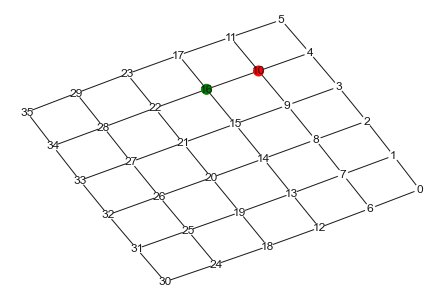

In [157]:
color_map = []
for cur_node in G:
    if cur_node == cur_cop_nodes[0]:
        color_map.append('red')
    elif cur_node == cur_cop_nodes[1]:
        color_map.append('green')
    elif cur_node == cur_cop_nodes[2]:
        color_map.append('blue')
    elif cur_node == cur_rob_node:
        color_map.append('black')
    else:
        color_map.append('white')

nx.draw(G, nx.kamada_kawai_layout(G), node_color=color_map, with_labels=True, node_size=100)

cur_cop_nodes = MoveNode(cur_cop_nodes, cur_rob_node)